# Skin Disease Detection using Mobile Application
## Final Year Project 2
Ahmad Daniel Ikhwan Bin Rosli <br>
1201103071

### Dataset Preprocessing and Model Trainning 

In this notebook we wil preprocess our final_dataset. Then we will use the preprocessed final_dataset to train and compare three lightweight deep learing architectures:
- MobileNet
- MobileNetV2
- MobileNetV3

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping

In [2]:

AUTOTUNE = tf.data.AUTOTUNE

### Preprocessing

In [3]:
final_dataset_path = Path("datasets/final_dataset")
img_size = (224, 224)
batch_size = 32

In [4]:
# load final_datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_path / "train", label_mode="categorical", batch_size=batch_size, shuffle=True, seed=42
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_path / "val", label_mode="categorical", batch_size=batch_size, shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    final_dataset_path / "test", label_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 6094 files belonging to 10 classes.
Found 758 files belonging to 10 classes.
Found 770 files belonging to 10 classes.


In [5]:
# resize with padding and normalize it
def resize_with_padding(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(resize_with_padding).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(resize_with_padding).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(resize_with_padding).cache().prefetch(AUTOTUNE)

In [6]:
# image augmentation we do this before training to make it as a controled variable so we can compare each model fairly later on
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),                      
    layers.RandomRotation(0.1),                           
    layers.RandomZoom(0.1),                               
    layers.RandomTranslation(0.1, 0.1),                   
    layers.RandomBrightness(factor=0.2)                   
])

def preprocess_with_augmentation(image, label):
    image = data_augmentation(image, training=True)
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess_with_augmentation).cache().prefetch(AUTOTUNE)

### Train Model

In [ ]:
# model builder first layer
def build_model(base_model, input_shape=(224, 224, 3), num_classes=10):
    base_model.trainable = False
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:

# our models that will be trained
base_models = {
    "MobileNet": MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV3Small": MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
}

In [ ]:
# train first layer model
histories = {}

for name, base_model in base_models.items():
    print(f"Training model: {name}")
    
    model = build_model(base_model)  
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1
    )

    histories[name] = history

Training model: MobileNet
Epoch 1/10


191/191 ━━━━━━━━━━━━━━━━━━━━ 99s 506ms/step - accuracy: 0.1327 - loss: 2.2963 - val_accuracy: 0.0897 - val_loss: 2.8984
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 71s 369ms/step - accuracy: 0.1366 - loss: 2.2838 - val_accuracy: 0.0937 - val_loss: 3.0536
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 73s 381ms/step - accuracy: 0.1390 - loss: 2.2680 - val_accuracy: 0.1108 - val_loss: 3.3925
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 70s 365ms/step - accuracy: 0.1384 - loss: 2.2733 - val_accuracy: 0.1121 - val_loss: 3.7982
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 358ms/step - accuracy: 0.1411 - loss: 2.2682 - val_accuracy: 0.1108 - val_loss: 4.3211
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 357ms/step - accuracy: 0.1469 - loss: 2.2630 - val_accuracy: 0.1069 - val_loss: 4.9955
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 66s 348ms/step - accuracy: 0.1400 - loss: 2.2640 - val_accuracy: 0.1055 - val_loss: 5.5518
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 352ms/step - accuracy: 0.1449 - loss: 2.2619 - val

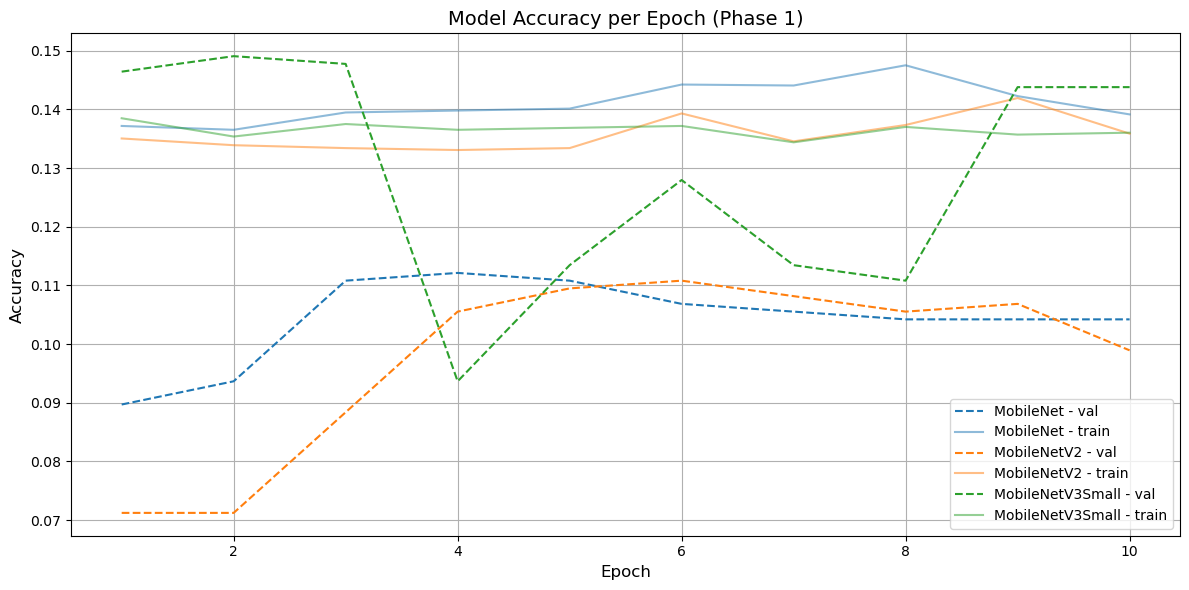

In [11]:
# compare first layer model
plt.figure(figsize=(12, 6))

colors = {
    "MobileNet": "#1f77b4",       
    "MobileNetV2": "#ff7f0e",     
    "MobileNetV3Small": "#2ca02c" 
}

for name, history in histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    color = colors.get(name, None)

    plt.plot(epochs, val_acc, label=f"{name} - val", linestyle='--', color=color)
    plt.plot(epochs, acc, label=f"{name} - train", linestyle='-', alpha=0.5, color=color)

plt.title("Model Accuracy per Epoch (Phase 1)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(visible=True)
plt.tight_layout()
plt.show()

In [15]:
# train second layer model to fine tune
fine_tune_histories = {}

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

for name, base_model in base_models.items():
    print(f"Fine-tuning model: {name}")

    base_model.trainable = True

    model = build_model(base_model)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10, 
        callbacks=[early_stopping],
        verbose=1
    )

    fine_tune_histories[name] = history


Fine-tuning model: MobileNet
Epoch 1/10


191/191 ━━━━━━━━━━━━━━━━━━━━ 72s 368ms/step - accuracy: 0.1377 - loss: 2.4609 - val_accuracy: 0.0726 - val_loss: 3.1272
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 361ms/step - accuracy: 0.1312 - loss: 2.4085 - val_accuracy: 0.0765 - val_loss: 3.0920
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 362ms/step - accuracy: 0.1301 - loss: 2.3900 - val_accuracy: 0.0831 - val_loss: 3.0730
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 357ms/step - accuracy: 0.1267 - loss: 2.3494 - val_accuracy: 0.0831 - val_loss: 3.0658
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 358ms/step - accuracy: 0.1416 - loss: 2.3268 - val_accuracy: 0.0871 - val_loss: 3.0678
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 362ms/step - accuracy: 0.1418 - loss: 2.3115 - val_accuracy: 0.0871 - val_loss: 3.0739
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 69s 364ms/step - accuracy: 0.1434 - loss: 2.2998 - val_accuracy: 0.0884 - val_loss: 3.0837
Fine-tuning model: MobileNetV2
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 432ms/step - accura

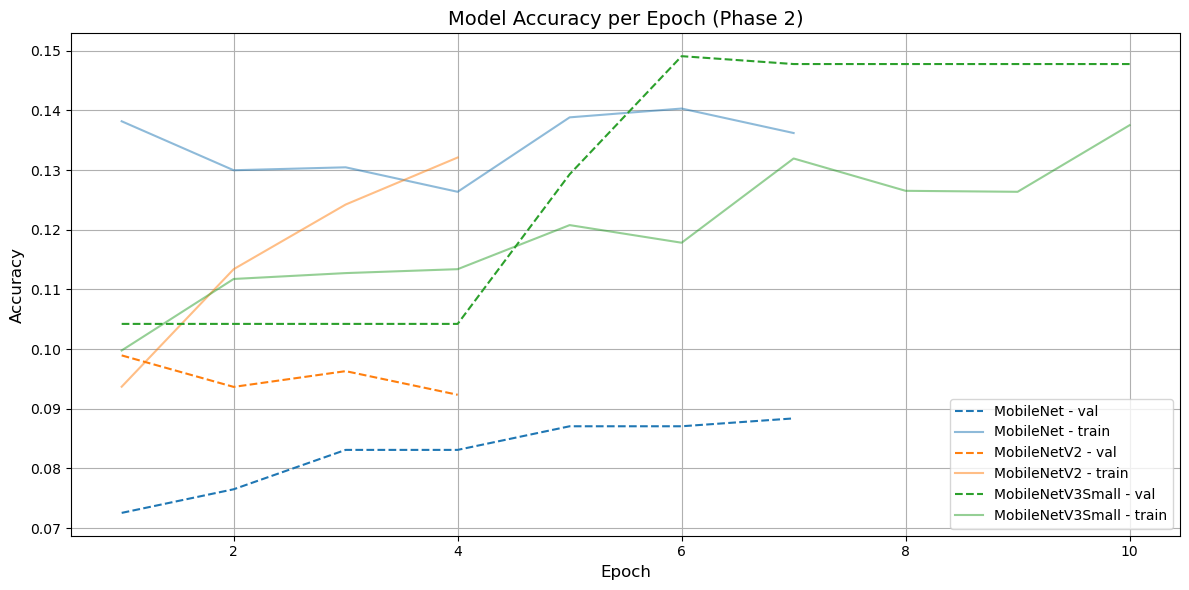

In [16]:
# compare second layer model
plt.figure(figsize=(12, 6))

colors = {
    "MobileNet": "#1f77b4",       
    "MobileNetV2": "#ff7f0e",     
    "MobileNetV3Small": "#2ca02c" 
}

for name, history in fine_tune_histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    color = colors.get(name, None)

    plt.plot(epochs, val_acc, label=f"{name} - val", linestyle='--', color=color)
    plt.plot(epochs, acc, label=f"{name} - train", linestyle='-', alpha=0.5, color=color)

plt.title("Model Accuracy per Epoch (Phase 2)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc="best", fontsize=10)
plt.grid(visible=True)
plt.tight_layout()
plt.show()